In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn.functional as F
import cv2
import os.path

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
np.load.__defaults__=(None, True, True, 'ASCII')

In [2]:
class HParams():
    def __init__(self):
        self.data_location = '../Datasets/cat.npz'
        self.train_photo_image_path = "../Datasets/cat/train/"
        self.test_photo_image_path = "../Datasets/cat/test/"
        self.image_size = 28
        self.bottleneck_size = 128
        self.enc_hidden_size = 256
        self.dec_hidden_size = 512
        self.Nz = 128
        self.M = 20
        self.dropout = 0.9
        self.batch_size = 100
        self.eta_min = 0.01
        self.R = 0.99995
        self.KL_min = 0.2
        self.wKL = 0.5
        self.lr = 0.001
        self.lr_decay = 0.9999
        self.min_lr = 0.00001
        self.grad_clip = 1.
        self.temperature = 0.4
        self.max_seq_length = 200

hp = HParams()

In [3]:
def max_size(data):
    """larger sequence length in the data set"""
    sizes = [len(seq) for seq in data]
    return max(sizes)

def purify(strokes):
    """removes to small or too long sequences + removes large gaps"""
    data = []
    for seq in strokes:
        if seq.shape[0] <= hp.max_seq_length and seq.shape[0] > 10:
            seq = np.minimum(seq, 1000)
            seq = np.maximum(seq, -1000)
            seq = np.array(seq, dtype=np.float32)
            data.append(seq)
    return data

def calculate_normalizing_scale_factor(strokes):
    """Calculate the normalizing factor explained in appendix of sketch-rnn."""
    data = []
    for i in range(len(strokes)):
        for j in range(len(strokes[i])):
            data.append(strokes[i][j, 0])
            data.append(strokes[i][j, 1])
    data = np.array(data)
    return np.std(data)

def normalize(strokes):
    """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
    data = []
    scale_factor = calculate_normalizing_scale_factor(strokes)
    for seq in strokes:
        seq[:, 0:2] /= scale_factor
        data.append(seq)
    return data

In [4]:
def make_batch(batch_size):
    # number of sketches in the dataset
    batch_idx = np.random.choice(len(data),batch_size)
    batch_sequences = [data[idx] for idx in batch_idx]
    strokes = []
    lengths = []
    indice = 0
    
    # convert each stroke to stroke-5 representation
    for seq in batch_sequences:
        len_seq = len(seq[:,0])
        new_seq = np.zeros((Nmax,5)) # 66,5
        new_seq[:len_seq,:2] = seq[:,:2]
        new_seq[:len_seq-1,2] = 1-seq[:-1,2]
        new_seq[:len_seq,3] = seq[:,2]
        new_seq[(len_seq-1):,4] = 1
        new_seq[len_seq-1,2:4] = 0
        lengths.append(len(seq[:,0]))
        strokes.append(new_seq)
        indice += 1

    if use_cuda:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).cuda().float())
    else:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).float())
    return batch, lengths, batch_idx

def select_images(indexes):
    paths = []
    for i in indexes:
        paths.append(f"{hp.train_photo_image_path}{i}.png")
    return paths

In [5]:
def lr_decay(optimizer):
    """Decay learning rate by a factor of lr_decay"""
    for param_group in optimizer.param_groups:
        if param_group['lr']>hp.min_lr:
            param_group['lr'] *= hp.lr_decay
    return optimizer

In [6]:
import matplotlib.image as mpimg

def rgb2gray(rgb):

    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [7]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(400, 128)  # 6*6 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

    def forward(self, image_paths):
        all_zs = torch.empty(0, 128)
        # Max pooling over a (2, 2) window
        for i, data in enumerate(image_paths):
            img = mpimg.imread(data)
            gray = rgb2gray(img)
            x = torch.from_numpy(gray)
            # change (28,28) to (1,1,28,28)
            x = torch.unsqueeze(x,0)
            x = torch.unsqueeze(x,0)
            #print(f"dimension of x {x.shape}")
            x = F.max_pool2d(F.relu(self.conv1(x.float())), (2, 2))
            # If the size is a square you can only specify a single number
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = x.view(-1, self.num_flat_features(x))
            
            #print(x.shape) #1 x 400
            x = self.fc1(x)
            #print(all_zs.shape)
            all_zs = torch.cat([all_zs, x], dim=0)
            #all_zs.cat(x)
        return all_zs

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        # bidirectional lstm:
        self.lstm = nn.LSTM(5, hp.enc_hidden_size, \
            dropout=hp.dropout, bidirectional=True)
        # create mu and sigma from lstm's last output:
        self.fc_mu = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        self.fc_sigma = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        # active dropout:
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # then must init with zeros
            if use_cuda:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
            else:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size)
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size)
            hidden_cell = (hidden, cell)
        _, (hidden,cell) = self.lstm(inputs.float(), hidden_cell)
        # hidden is (2, batch_size, hidden_size), we want (batch_size, 2*hidden_size):
        hidden_forward, hidden_backward = torch.split(hidden,1,0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)],1)
        # mu and sigma:
        mu = self.fc_mu(hidden_cat)
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat/2.)
        # N ~ N(0,1)
        z_size = mu.size()
                                   
        if use_cuda:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size)).cuda()
        else:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size))
        z = mu + sigma*N
        # mu and sigma_hat are needed for LKL loss
        return z, mu, sigma_hat #[100,128]

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        # to init hidden and cell from z:
        self.fc_hc = nn.Linear(hp.Nz, 2*hp.dec_hidden_size)
        # unidirectional lstm:
        self.lstm = nn.LSTM(hp.Nz+5, hp.dec_hidden_size, dropout=hp.dropout)
        # create proba distribution parameters from hiddens:
        self.fc_params = nn.Linear(hp.dec_hidden_size,6*hp.M+3)

    def forward(self, inputs, z, hidden_cell=None):
        if hidden_cell is None:
            # then we must init from z
            hidden,cell = torch.split(F.tanh(self.fc_hc(z)),hp.dec_hidden_size,1)
            hidden_cell = (hidden.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous())
        outputs,(hidden,cell) = self.lstm(inputs, hidden_cell)
        # in training we feed the lstm with the whole input in one shot
        # and use all outputs contained in 'outputs', while in generate
        # mode we just feed with the last generated sample:
        if self.training:
            y = self.fc_params(outputs.view(-1, hp.dec_hidden_size))
        else:
            y = self.fc_params(hidden.view(-1, hp.dec_hidden_size))
        # separate pen and mixture params:
        params = torch.split(y,6,1)
        params_mixture = torch.stack(params[:-1]) # trajectory
        params_pen = params[-1] # pen up/down
        # identify mixture params:
        pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy = torch.split(params_mixture,1,2)
        # preprocess params::
        if self.training:
            len_out = Nmax+1
        else:
            len_out = 1
                                   
        pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_x = torch.exp(sigma_x.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_y = torch.exp(sigma_y.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        rho_xy = torch.tanh(rho_xy.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        mu_x = mu_x.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        mu_y = mu_y.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        q = F.softmax(params_pen).view(len_out,-1,3)
        return pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy,q,hidden,cell

In [10]:
class Model():
    def __init__(self):
        if use_cuda:
            self.encoderRNN = EncoderRNN().cuda()
            saved_encoder = torch.load('../Models/sketchRNN_encoder_0.320616_7000.pt')
            self.encoderRNN.load_state_dict(saved_encoder)
            self.encoder = ImageEncoder().cuda()
            self.decoder = DecoderRNN().cuda()
        else:
            self.encoderRNN = EncoderRNN()
            saved_encoder = torch.load('../Models/sketchRNN_encoder_0.320616_7000.pt')
            self.encoderRNN.load_state_dict(saved_encoder)
            self.encoder = ImageEncoder()
            self.decoder = DecoderRNN()
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), hp.lr)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), hp.lr)
        self.eta_step = hp.eta_min

    def make_target(self, batch, lengths):
        if use_cuda:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).cuda().unsqueeze(0)
        else:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).unsqueeze(0)
        batch = torch.cat([batch, eos], 0)
        mask = torch.zeros(Nmax+1, batch.size()[1])
        for indice,length in enumerate(lengths):
            mask[:length,indice] = 1
        if use_cuda:
            mask = mask.cuda()
        dx = torch.stack([batch.data[:,:,0]]*hp.M,2)
        dy = torch.stack([batch.data[:,:,1]]*hp.M,2)
        p1 = batch.data[:,:,2]
        p2 = batch.data[:,:,3]
        p3 = batch.data[:,:,4]
        p = torch.stack([p1,p2,p3],2)
        return mask,dx,dy,p

    def train(self, epoch):
        self.encoder.train()
        self.decoder.train()
        
        # EncoderRNN(a batch of sequences) -> a single z
        # ImageEncoder(a batch of images) -> single z
                # EncoderRNN(same corresponsing batch of images) -> single z
        # single image x single sequence
        
        batch, lengths, indexes = make_batch(hp.batch_size)
        
        img_paths = select_images(indexes)
        
        # RNN encoder:
        target_z, self.mu, self.sigma = self.encoderRNN(batch, hp.batch_size)

        # Image encoder:
        predicted_z = self.encoder(img_paths)
        
        # create start of sequence:
        if use_cuda:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).cuda().unsqueeze(0)
        else:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).unsqueeze(0)
        # had sos at the begining of the batch:
        batch_init = torch.cat([sos, batch],0)
        # expend z to be ready to concatenate with inputs:
        z_stack = torch.stack([predicted_z]*(Nmax+1))
        # inputs is concatenation of z and batch_inputs
        inputs = torch.cat([batch_init, z_stack],2)
        
        # decode:
        self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
            self.rho_xy, self.q, _, _ = self.decoder(inputs, predicted_z)
        # prepare targets:
        mask,dx,dy,p = self.make_target(batch, lengths)
        
        # prepare optimizers:
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        
        # update eta for LKL:
        self.eta_step = 1-(1-hp.eta_min)*hp.R
        
        # compute losses:
        LKL = self.kullback_leibler_loss()
        LR = self.reconstruction_loss(mask,dx,dy,p,epoch)
        EL = self.encoder_loss(predicted_z, target_z)
        
        loss = LR + LKL + (EL * 2) 
        
        # gradient step
        loss.backward()
        
        # gradient cliping
        nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
        nn.utils.clip_grad_norm(self.decoder.parameters(), hp.grad_clip)
        
        # optim step
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        
        # some print and save:
        if epoch%1==0:
            print(f"The number of epochs is: {epoch} and loss is {loss}")
            self.encoder_optimizer = lr_decay(self.encoder_optimizer)
            self.decoder_optimizer = lr_decay(self.decoder_optimizer)
        if epoch%100==0:
            self.save(epoch)
            #self.conditional_generation(epoch)

    def bivariate_normal_pdf(self, dx, dy):
        z_x = ((dx-self.mu_x)/self.sigma_x)**2
        z_y = ((dy-self.mu_y)/self.sigma_y)**2
        z_xy = (dx-self.mu_x)*(dy-self.mu_y)/(self.sigma_x*self.sigma_y)
        z = z_x + z_y -2*self.rho_xy*z_xy
        exp = torch.exp(-z/(2*(1-self.rho_xy**2)))
        norm = 2*np.pi*self.sigma_x*self.sigma_y*torch.sqrt(1-self.rho_xy**2)
        return exp/norm
    
    def encoder_loss(self, pred_z, target_z):
        criterion = nn.MSELoss()
        return criterion(pred_z, target_z)

    def reconstruction_loss(self, mask, dx, dy, p, epoch):
        pdf = self.bivariate_normal_pdf(dx, dy)
        LS = -torch.sum(mask*torch.log(1e-5+torch.sum(self.pi * pdf, 2)))\
            /float(Nmax*hp.batch_size)
        LP = -torch.sum(p*torch.log(self.q))/float(Nmax*hp.batch_size)
        return LS+LP

    def kullback_leibler_loss(self):
        LKL = -0.5*torch.sum(1+self.sigma-self.mu**2-torch.exp(self.sigma))\
            /float(hp.Nz*hp.batch_size)
        if use_cuda:
            KL_min = Variable(torch.Tensor([hp.KL_min]).cuda()).detach()
        else:
            KL_min = Variable(torch.Tensor([hp.KL_min])).detach()
        return hp.wKL*self.eta_step * torch.max(LKL,KL_min)

    def save(self, epoch):
        random_number = np.random.rand()
        enc_model_name = 'sketchRNN_encoder_%3f_%d.pt' % (random_number, epoch)
        enc_path = F"../Models_Complete/{enc_model_name}"
        torch.save(self.encoder.state_dict(), enc_path)
        dec_model_name = 'sketchRNN_decoder_%3f_%d.pt' % (random_number, epoch)
        dec_path = F"../Models_Complete/{dec_model_name}"
        torch.save(self.decoder.state_dict(), dec_path)

    def load(self, encoder_name, decoder_name):
        saved_encoder = torch.load(encoder_name)
        saved_decoder = torch.load(decoder_name)
        self.encoder.load_state_dict(saved_encoder)
        self.decoder.load_state_dict(saved_decoder)

    def conditional_generation(self, z):
        #batch,lengths = make_batch(1)
        # should remove dropouts:
        self.encoder.train(False)
        self.decoder.train(False)
        # encode:
        #z, _, _ = self.encoder(batch, 1)
        if use_cuda:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1).cuda())
        else:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1))
        s = sos
        seq_x = []
        seq_y = []
        seq_z = []
        hidden_cell = None
        for i in range(Nmax):
            input = torch.cat([s,z.unsqueeze(0)],2)
            # decode:
            self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
                self.rho_xy, self.q, hidden, cell = \
                    self.decoder(input, z, hidden_cell)
            hidden_cell = (hidden, cell)
            # sample from parameters:
            s, dx, dy, pen_down, eos = self.sample_next_state()
            #------
            seq_x.append(dx)
            seq_y.append(dy)
            seq_z.append(pen_down)
            if eos:
                print(i)
                break
        # visualize result:
        x_sample = np.cumsum(seq_x, 0)
        y_sample = np.cumsum(seq_y, 0)
        z_sample = np.array(seq_z)
        sequence = np.stack([x_sample,y_sample,z_sample]).T
        make_image(sequence)
        
    def getStrokesToPlot(self, z):
        self.encoder.train(False)
        self.decoder.train(False)
        if use_cuda:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1).cuda())
        else:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1))
        s = sos
        seq_x = []
        seq_y = []
        seq_z = []
        hidden_cell = None
        for i in range(Nmax):
            input = torch.cat([s,z.unsqueeze(0)],2)
            # decode:
            self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
                self.rho_xy, self.q, hidden, cell = \
                    self.decoder(input, z, hidden_cell)
            hidden_cell = (hidden, cell)
            # sample from parameters:
            s, dx, dy, pen_down, eos = self.sample_next_state()
            #------
            seq_x.append(dx)
            seq_y.append(dy)
            seq_z.append(pen_down)
            if eos:
                print(i)
                break
        # visualize result:
        x_sample = np.cumsum(seq_x, 0)
        y_sample = np.cumsum(seq_y, 0)
        z_sample = np.array(seq_z)
        sequence = np.stack([x_sample,y_sample,z_sample]).T
        return sequence

    def sample_next_state(self):
        def adjust_temp(pi_pdf):
            pi_pdf = np.log(pi_pdf)/hp.temperature
            pi_pdf -= pi_pdf.max()
            pi_pdf = np.exp(pi_pdf)
            pi_pdf /= pi_pdf.sum()
            return pi_pdf

        # get mixture indice:
        pi = self.pi.data[0,0,:].cpu().numpy()
        pi = adjust_temp(pi)
        pi_idx = np.random.choice(hp.M, p=pi)
        # get pen state:
        q = self.q.data[0,0,:].cpu().numpy()
        q = adjust_temp(q)
        q_idx = np.random.choice(3, p=q)
        # get mixture params:
        mu_x = self.mu_x.data[0,0,pi_idx]
        mu_y = self.mu_y.data[0,0,pi_idx]
        sigma_x = self.sigma_x.data[0,0,pi_idx]
        sigma_y = self.sigma_y.data[0,0,pi_idx]
        rho_xy = self.rho_xy.data[0,0,pi_idx]
        x,y = sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy,greedy=False)
        next_state = torch.zeros(5)
        next_state[0] = x
        next_state[1] = y
        next_state[q_idx+2] = 1
        if use_cuda:
            return Variable(next_state.cuda()).view(1,1,-1),x,y,q_idx==1,q_idx==2
        else:
            return Variable(next_state).view(1,1,-1),x,y,q_idx==1,q_idx==2

def sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy, greedy=False):
    # inputs must be floats
    if greedy:
        return mu_x,mu_y
    mean = [mu_x, mu_y]
    sigma_x *= np.sqrt(hp.temperature)
    sigma_y *= np.sqrt(hp.temperature)
    cov = [[sigma_x * sigma_x, rho_xy * sigma_x * sigma_y],\
        [rho_xy * sigma_x * sigma_y, sigma_y * sigma_y]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

def make_image(sequence):
    """plot drawing with separated strokes"""
    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    for s in strokes:
        plt.plot(s[:,0],-s[:,1])
    #print("Outputting sketch")
    #name = str(epoch)+name+'.jpg'
    #plt.savefig(F"./outputs_complete/{name}")
    plt.show()


In [11]:
#Handling data

dataset = np.load(hp.data_location, encoding='latin1')
data = dataset['train']
data = purify(data)
data = normalize(data)
Nmax = max_size(data)

In [12]:
# model = Model()
# for epoch in range(50001):
#     model.train(epoch)

In [30]:
def preprocess_image(path):
    image = Image.open(path)
    new_image = image.resize((28, 28))
    new_image.save('../Datasets/photo_cat/cat.png')
    return '../Datasets/photo_cat/cat.png'

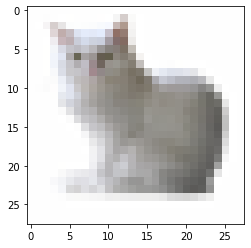

54


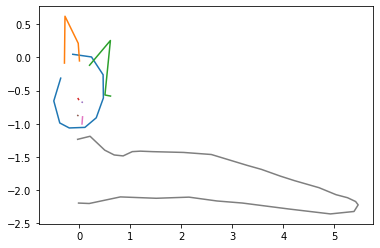

In [52]:
model = Model()
model.load('../Models_Complete/sketchRNN_encoder_0.575094_10900.pt', '../Models_Complete/sketchRNN_decoder_0.575094_10900.pt')

# # Data comes from test set now
dataset = np.load(hp.data_location, encoding='latin1')
data = dataset['test']
data = purify(data)
data = normalize(data)
Nmax = max_size(data)

# sketch, length, indexes = make_batch(1)
# img_paths = []
# for i in indexes:
#     img_paths.append(f"{hp.test_photo_image_path}{i}.png")   
#     img_path = f"{hp.test_photo_image_path}{i}.png"    
#     img = mpimg.imread(img_path)
#     imgplot = plt.imshow(img)
#     plt.show()


img_path = preprocess_image('../Datasets/photo_cat/cat_5.jpeg')   
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()
z_1 = model.encoder([img_path])
model.conditional_generation(z_1)

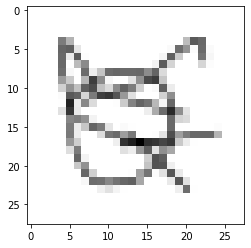

46


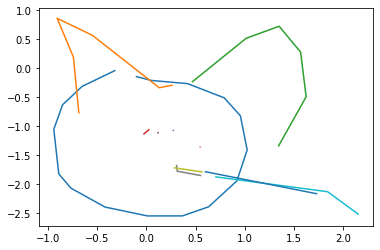

In [40]:
# """
# Test Model:
# - Using test dataset, get first test seq stroke and first image
#                     --> Plot the first seq stroke
#                     --> Plot the first sketch after passing through our saved encoder + decoder
# - Show images side by side
# """

model = Model()
model.load('../Models_Complete/sketchRNN_encoder_0.575094_10900.pt', '../Models_Complete/sketchRNN_decoder_0.575094_10900.pt')

# # Data comes from test set now
dataset = np.load(hp.data_location, encoding='latin1')
data = dataset['test']
data = purify(data)
data = normalize(data)
Nmax = max_size(data)

sketch, length, indexes = make_batch(1)
img_paths = []
for i in indexes:
    img_paths.append(f"{hp.test_photo_image_path}{i}.png")   
    img_path = f"{hp.test_photo_image_path}{i}.png"    
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
        
z_1 = model.encoder(img_paths)
model.conditional_generation(z_1)

In [14]:
# encoder = EncoderRNN()
# decder = DecoderRNN()
# encoder.load('../Models/sketchRNN_encoder_0.320616_7000.pt')
# decoder.load('../Models/sketchRNN_decoder_0.320616_7000.pt')

In [15]:
# for i in range(69999):
#     if os.path.isfile(f"{train_photo_image_path}{i}.png") == False:
#         print(i)
#         break
        
# # remember - 9336

In [16]:
# # Use conditional generation function to test model

# model = Model()
# # not the best model
# model.load('../Models/sketchRNN_encoder_0.497555_1600.pt','../Models/sketchRNN_decoder_0.497555_1600.pt')
# for i in range(50001):
#     model.conditional_generation(i)
    
# # choose best model
# # 
# # [sketch, latent vector]
# # choose best 40 sketches -> save zs in set
# # for each sketch in 
